In [2]:
import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
import sys
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")


sys.path.insert(0, '..')
from utils import *
from rec import Rec
import h5py
%matplotlib inline

## Sizes and propagation settings

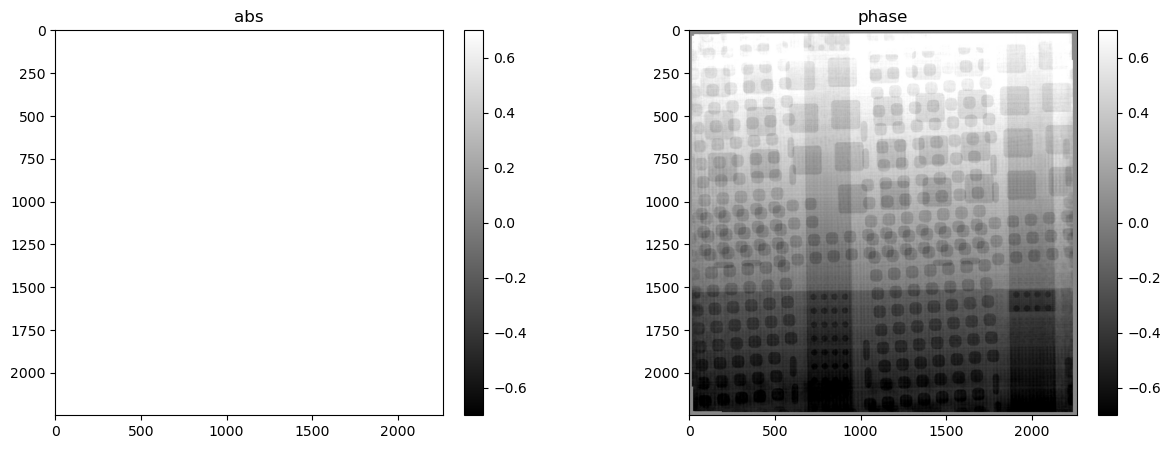

In [11]:
with h5py.File('/data/vnikitin/ESRF/ID16A/20240924/Chip/Chip_010nm_nfpPSEUDO_RANDOM/recon/Chip_010nm_nfpPSEUDO_RANDOM_run01.cxi') as fid:
    d = fid['/entry_1/object/data'][:]
mshow_polar(d[0],True,vmax=0.7,vmin=-0.7)


In [3]:
args = SimpleNamespace()

args.ngpus = 4#int(sys.args[1])
args.lam = 0.0#float(sys.args[2])

args.n = 2048
args.npsi = args.n+args.n // 8
args.pad = 0# args.n // 8
args.nq = args.n + 2 * args.pad
args.ex = 0#16
args.npatch = args.nq + 2 * args.ex
args.npos = 16
args.nchunk = 1

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.eps = 1e-12
args.rho = [1, 2, 0.1]
args.crop = 2 * args.pad
args.path_out = f"/data/vnikitin/ESRF/ID16A/20240924_rec0224/Chip_nfp10nm/{args.lam}/"

args.niter = 10000
args.err_step = 1
args.vis_step = 64
args.method = "BH-CG"
args.show = True

# create class
cl_rec = Rec(args)

## read data

In [4]:
import h5py

with h5py.File(f"{path}/Chip_010nm_nfpPSEUDO_RANDOM0000.h5") as fid:
    data = fid["/entry_0000/measurement/data"][: args.npos].astype("float32")

with h5py.File(f"{path}/Chip_010nm_nfpPSEUDO_RANDOM0000.h5") as fid:
    ref = fid["/entry_0000/measurement/data"][:].astype("float32")
with h5py.File(f"{path}/dark_0000.h5") as fid:
    dark = fid["/entry_0000/measurement/data"][:].astype("float32")

with h5py.File(f'{path}Chip_010nm_nfpPSEUDO_RANDOM0000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize


pos_init = np.zeros([args.npos,2],dtype='float32')
pos_init[:,1] = spy
pos_init[:,0] = -spz
# pos_init=-pos_init

# plt.plot(pos_init[:,1],pos_init[:,0],'.')
# print(spz)
# print(spy)


# remove outliers from data

In [ ]:
import cupyx.scipy.ndimage as ndimage


def remove_outliers(data, dezinger, dezinger_threshold):
    res = data.copy()
    w = [dezinger, dezinger]
    for k in range(data.shape[0]):
        data0 = cp.array(data[k])
        fdata = ndimage.median_filter(data0, w)
        print(np.sum(np.abs(data0 - fdata) > fdata * dezinger_threshold))
        res[k] = np.where(
            np.abs(data0 - fdata) > fdata * dezinger_threshold, fdata, data0
        ).get()
    return res


dark = np.mean(dark, axis=0)
ref = np.mean(ref, axis=0)
data -= dark
ref -= dark

data[data < 0] = 0
ref[ref < 0] = 0
data[:, 1320//3 : 1320//3 + 25//3 , 890//3 : 890//3 + 25//3 ] = data[
    :, 1280//3 : 1280//3 + 25//3 , 890//3 : 890//3 + 25//3 
]
ref[1320//3 : 1320//3 + 25//3 , 890//3 : 890//3 + 25//3 ] = ref[
    1280//3 : 1280//3 + 25//3 , 890//3 : 890//3 + 25//3 
]

data = remove_outliers(data, 5, 0.995)
ref = remove_outliers(ref[None], 5, 0.995)[0]

data /= np.mean(ref)
ref /= np.mean(ref)

data[np.isnan(data)] = 1
ref[np.isnan(ref)] = 1

mshow(data[0],args.show)
mshow(ref,args.show)

# initial guess for the object

In [ ]:
def Paganin(data, wavelength, voxelsize, delta_beta, alpha):
    fx = cp.fft.fftfreq(data.shape[-1], d=voxelsize).astype("float32")
    [fx, fy] = cp.meshgrid(fx, fx)
    rad_freq = cp.fft.fft2(data)
    taylorExp = 1 + wavelength * distance * cp.pi * (delta_beta) * (fx**2 + fy**2)
    numerator = taylorExp * (rad_freq)
    denominator = taylorExp**2 + alpha
    phase = cp.log(cp.real(cp.fft.ifft2(numerator / denominator)))
    phase = delta_beta * 0.5 * phase
    return phase


def rec_init(rdata, ipos_init):
    recMultiPaganin = cp.zeros([args.npsi, args.npsi], dtype="float32")
    recMultiPaganinr = cp.zeros(
        [args.npsi, args.npsi], dtype="float32"
    )  # to compensate for overlap
    for j in range(0, args.npos):
        r = cp.array(rdata[j])
        r = Paganin(r, wavelength, voxelsize, 24.05, 1e-2)
        rr = r * 0 + 1  # to compensate for overlap
        rpsi = cp.zeros([args.npsi, args.npsi], dtype="float32")
        rrpsi = cp.zeros([args.npsi, args.npsi], dtype="float32")
        stx = args.npsi // 2 - ipos_init[j, 1] - args.n // 2
        endx = stx + args.n
        sty = args.npsi // 2 - ipos_init[j, 0] - args.n // 2
        endy = sty + args.n
        rpsi[sty:endy, stx:endx] = r
        rrpsi[sty:endy, stx:endx] = rr

        recMultiPaganin += rpsi
        recMultiPaganinr += rrpsi

    recMultiPaganinr[np.abs(recMultiPaganinr) < 5e-2] = 1
    recMultiPaganin /= recMultiPaganinr
    recMultiPaganin = np.exp(1j * recMultiPaganin)
    return recMultiPaganin


ipos_init = np.round(np.array(pos_init)).astype("int32")
rdata = np.array(data / (ref + 1e-5))
psi_init = rec_init(rdata, ipos_init)
mshow_polar(psi_init,args.show)
mshow_polar(psi_init[:1000, :1000],args.show)

# smooth borders
v = cp.arange(-args.npsi // 2,args.npsi // 2) / args.npsi
[vx, vy] = cp.meshgrid(v, v)
v = cp.exp(-1000 * (vx**2 + vy**2)).astype("float32")

psi_init = cp.fft.fftshift(cp.fft.fftn(cp.fft.fftshift(psi_init)))
psi_init = cp.fft.fftshift(cp.fft.ifftn(cp.fft.fftshift(psi_init * v))).astype(
    "complex64"
)
v=[]
mshow_polar(psi_init,args.show)
mshow_polar(psi_init[:1000, :1000],args.show)

# rdata = v = []

#### Initial guess for the probe calculated by backpropagating the square root of the reference image
#### Smooth the probe borders for stability

In [ ]:
q_init = cp.array(cl_rec.DT(np.sqrt(ref[np.newaxis]))[0])

ppad = 3 * args.pad // 2
q_init = np.pad(
    q_init[ppad : args.nq - ppad, ppad : args.nq - ppad],
    ((ppad, ppad), (ppad, ppad)),
    "symmetric",
)
v = cp.ones(args.nq, dtype="float32")
vv = cp.sin(cp.linspace(0, cp.pi / 2, ppad))
v[:ppad] = vv
v[args.nq - ppad :] = vv[::-1]
v = cp.outer(v, v)
q_init = cp.abs(q_init * v) * cp.exp(1j * cp.angle(q_init) * v)
vv=[]
mshow_polar(q_init,args.show)

0) err=3.82318e+06


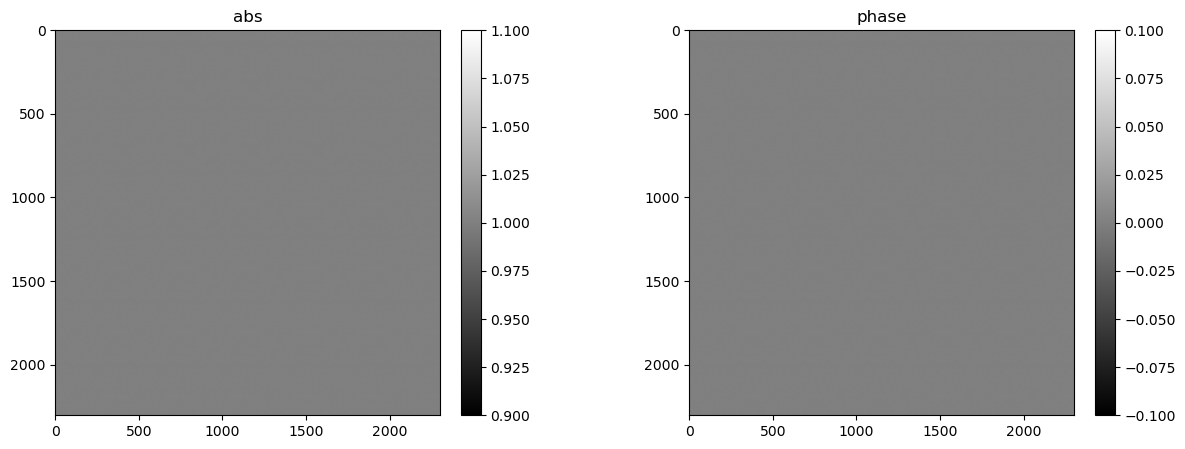

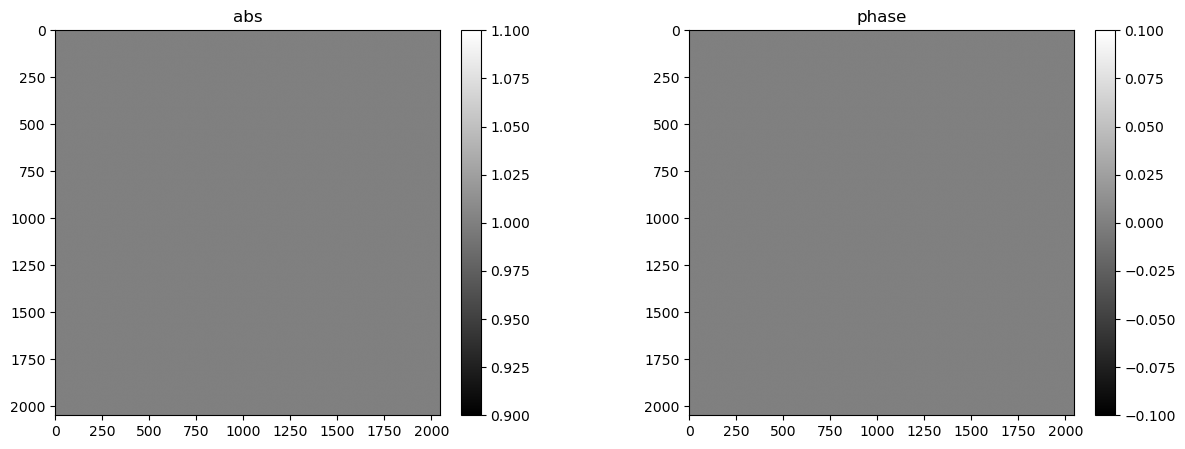

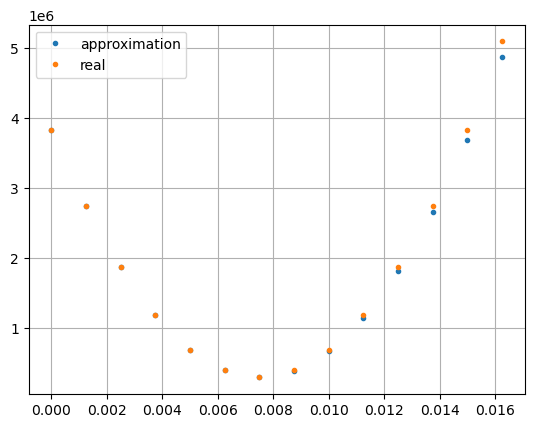

1) err=2.96757e+05
2) err=8.97406e+04
3) err=5.34147e+04
4) err=4.20898e+04
5) err=3.63210e+04
6) err=3.39984e+04
7) err=3.26935e+04
8) err=3.15886e+04
9) err=3.08428e+04
10) err=3.01476e+04
11) err=2.94139e+04
12) err=2.86717e+04
13) err=2.78736e+04
14) err=2.68834e+04
15) err=2.59677e+04
16) err=2.48828e+04
17) err=2.39664e+04
18) err=2.31191e+04
19) err=2.24057e+04
20) err=2.17347e+04
21) err=2.10774e+04
22) err=2.04293e+04
23) err=1.97922e+04
24) err=1.92066e+04
25) err=1.86518e+04
26) err=1.81259e+04
27) err=1.76358e+04
28) err=1.71717e+04
29) err=1.67446e+04
30) err=1.63464e+04
31) err=1.59738e+04
32) err=1.56336e+04
33) err=1.53182e+04
34) err=1.50308e+04
35) err=1.47613e+04
36) err=1.45140e+04
37) err=1.42801e+04
38) err=1.40627e+04
39) err=1.38633e+04
40) err=1.36711e+04
41) err=1.34956e+04
42) err=1.33231e+04
43) err=1.31652e+04
44) err=1.30131e+04
45) err=1.28717e+04
46) err=1.27373e+04
47) err=1.26095e+04
48) err=1.24887e+04
49) err=1.23749e+04
50) err=1.22642e+04
51) err=1

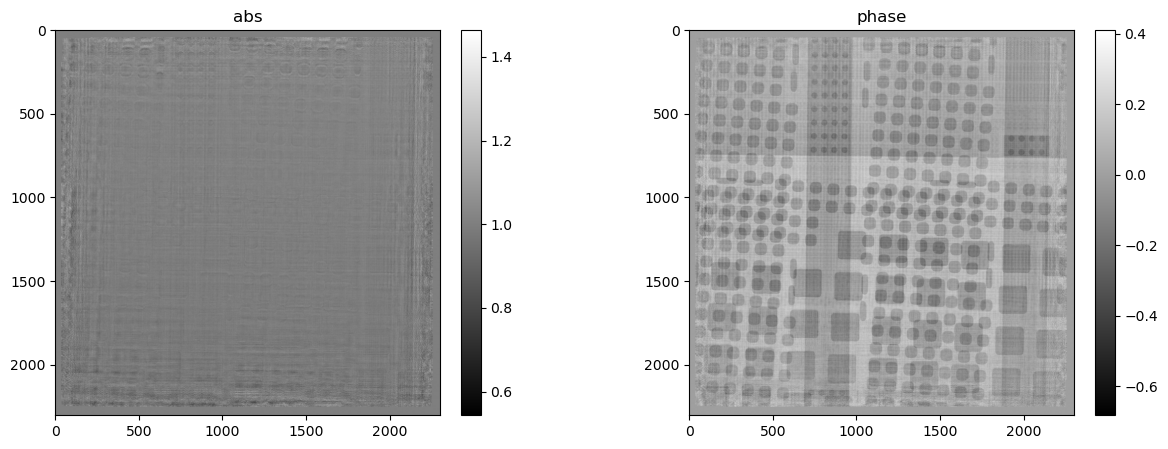

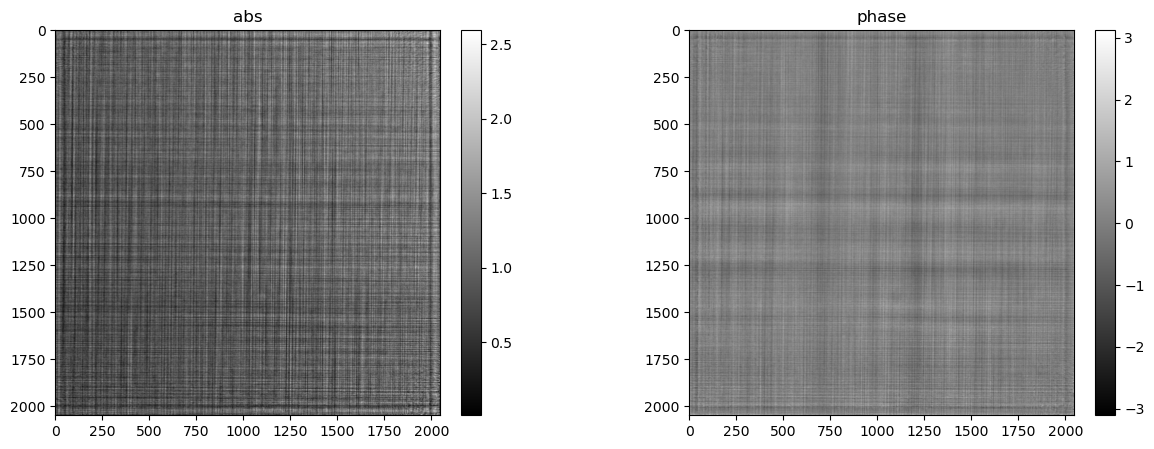

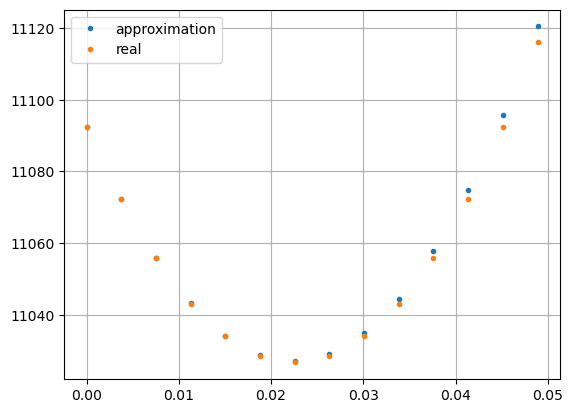

65) err=1.10270e+04
66) err=1.09628e+04
67) err=1.09006e+04
68) err=1.08395e+04
69) err=1.07804e+04
70) err=1.07226e+04
71) err=1.06660e+04
72) err=1.06104e+04
73) err=1.05564e+04
74) err=1.05033e+04
75) err=1.04519e+04
76) err=1.04008e+04
77) err=1.03516e+04
78) err=1.03029e+04
79) err=1.02559e+04
80) err=1.02093e+04
81) err=1.01643e+04
82) err=1.01200e+04
83) err=1.00768e+04
84) err=1.00347e+04
85) err=9.99361e+03
86) err=9.95323e+03
87) err=9.91414e+03
88) err=9.87576e+03
89) err=9.83889e+03
90) err=9.80220e+03
91) err=9.76709e+03
92) err=9.73215e+03
93) err=9.69870e+03
94) err=9.66552e+03
95) err=9.63333e+03
96) err=9.60191e+03
97) err=9.57118e+03
98) err=9.54109e+03
99) err=9.51179e+03
100) err=9.48290e+03
101) err=9.45485e+03
102) err=9.42710e+03
103) err=9.40018e+03
104) err=9.37355e+03
105) err=9.34759e+03
106) err=9.32210e+03
107) err=9.29716e+03
108) err=9.27264e+03
109) err=9.24856e+03
110) err=9.22493e+03
111) err=9.20174e+03
112) err=9.17898e+03
113) err=9.15666e+03
114) e

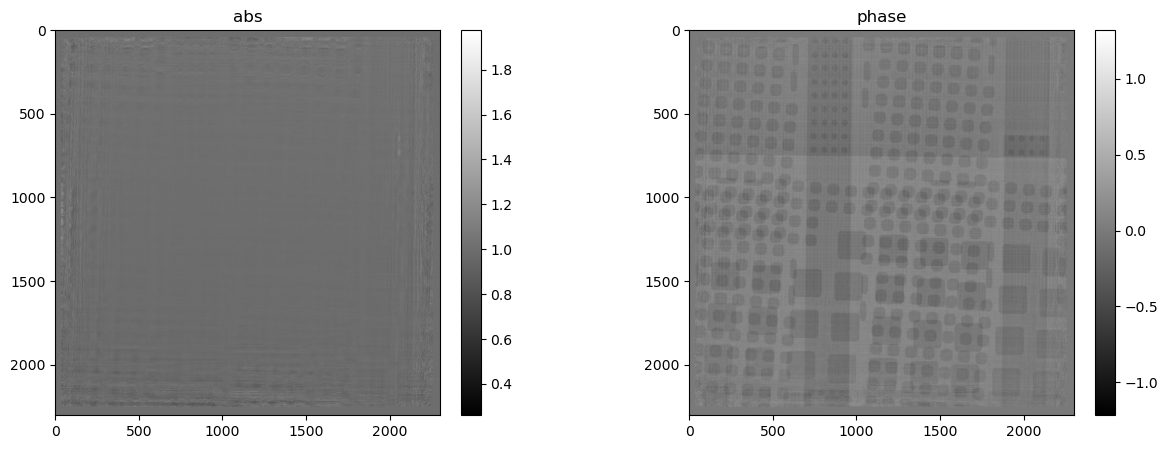

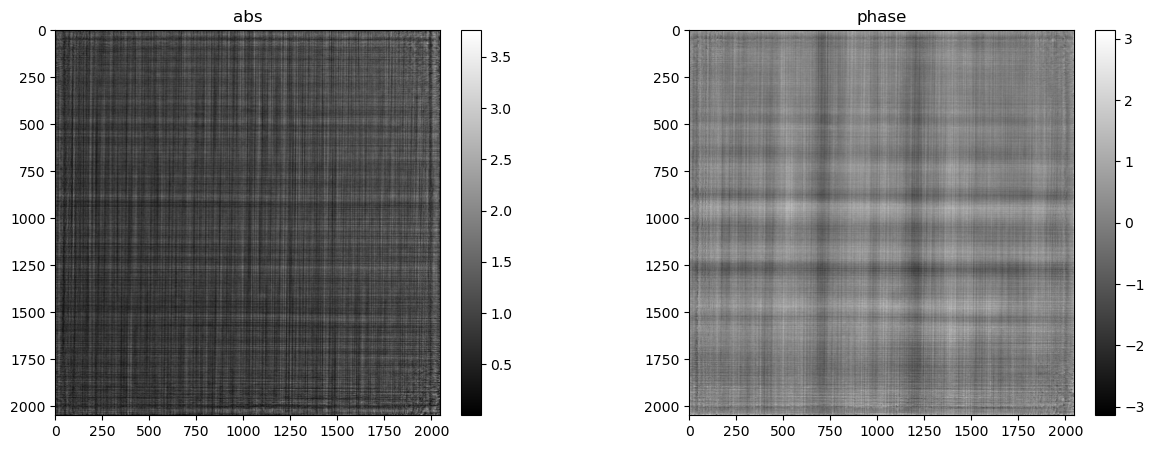

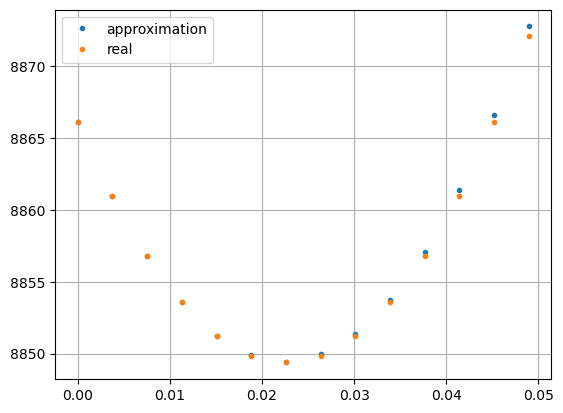

129) err=8.84944e+03
130) err=8.83289e+03
131) err=8.81678e+03
132) err=8.80082e+03


In [ ]:
# variables

vars = {}
vars["psi"] = cp.array(psi_init)*0+1
vars["q"] = cp.array(q_init)*0+1
vars["ri"] = np.round(pos_init).astype("int32")
vars["r"] = np.array(pos_init - vars["ri"]).astype("float32")
vars["r_init"] = np.array(pos_init - vars["ri"]).astype("float32")
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])

# reconstruction
vars = cl_rec.BH(data, vars)


In [ ]:
# results
erra = vars["table"]["err"].values
plt.plot(erra)
plt.yscale("log")
plt.grid()
mshow_polar(vars["psi"],args.show)
mshow_polar(vars["q"],args.show)
pos_rec = vars["ri"] + vars["r"]
if args.show:
    plt.plot((pos_init[:, 1] - pos_rec[:, 1]), ".", label="x difference")
    plt.plot((pos_init[:, 0] - pos_rec[:, 0]), ".", label="y difference")
    plt.legend()
    plt.grid()
    plt.plot()